# MIDI Music Generation - Training (Tick-Based)

Train a deep learning model for polyphonic piano music generation using **tick-based encoding**.

**Key improvements over piano roll:**
- 77% ticks have notes (vs 5% for piano roll) - much less sparse
- Explicit note duration (not just "on/off")
- Musical time quantization (16th notes)

**Models:** Mamba (recommended) or LSTM  
**Dataset:** ADL Piano MIDI  
**Output:** `midi_data/best_model_tick.pt`

## 1. Setup

In [4]:
import random
import time
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from midi_utils import (
    MIDI_CONFIG, NUM_PITCHES, TICK_FEATURES, SEQUENCE_LENGTH, STRIDE, SEED,
    TICKS_PER_BEAT, MAX_DURATION_TICKS, DEFAULT_TEMPO,
    get_device, midi_to_tick_sequence,
    MusicMamba, MusicLSTM, TickDataset
)

# Reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = get_device()
print(f"PyTorch version: {torch.__version__}")
print(f"Tick-based encoding: {TICKS_PER_BEAT} ticks/beat, {TICK_FEATURES} features/tick")

Using Apple Silicon MPS
PyTorch version: 2.9.1
Tick-based encoding: 4 ticks/beat, 176 features/tick


## 2. Load Dataset

In [5]:
DATA_DIR = Path("./midi_data")
ADL_DIR = DATA_DIR / "adl-piano-midi"

# Filter to a single genre for consistent style (or None for all)
GENRE_FILTER = None  # Use all genres - tick encoding handles diversity better

def load_adl_piano_midi(adl_dir: Path, genre_filter: str = None) -> list:
    """Load ADL Piano MIDI dataset, optionally filtered by genre."""
    files = []
    for midi_path in adl_dir.rglob("*.mid"):
        parts = midi_path.relative_to(adl_dir).parts
        genre = parts[0] if len(parts) >= 1 else "Unknown"
        if genre_filter is None or genre == genre_filter:
            files.append({"path": midi_path, "genre": genre})
    return files

def create_splits(files: list, train_ratio: float = 0.8, val_ratio: float = 0.1) -> dict:
    """Create train/validation/test splits."""
    random.seed(SEED)
    shuffled = files.copy()
    random.shuffle(shuffled)
    n = len(shuffled)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))
    return {
        "train": shuffled[:train_end],
        "validation": shuffled[train_end:val_end],
        "test": shuffled[val_end:]
    }

all_files = load_adl_piano_midi(ADL_DIR, genre_filter=GENRE_FILTER)
print(f"Genre filter: {GENRE_FILTER or 'None (all genres)'}")
print(f"Found {len(all_files)} MIDI files")

adl_splits = create_splits(all_files)
for split, files in adl_splits.items():
    print(f"  {split}: {len(files)} files")

Genre filter: None (all genres)
Found 11076 MIDI files
  train: 8860 files
  validation: 1108 files
  test: 1108 files


In [6]:
# Limit dataset size for faster iteration (set to None for full dataset)
MAX_FILES_PER_SPLIT = 200  # Start with 200 files for testing, None for full

if MAX_FILES_PER_SPLIT:
    for split in adl_splits:
        adl_splits[split] = adl_splits[split][:MAX_FILES_PER_SPLIT]
    print(f"Limited to {MAX_FILES_PER_SPLIT} files per split")
else:
    print(f"Using full dataset")

Limited to 200 files per split


## 3. Process MIDI Files

In [7]:
# Convert MIDI to tick sequences
tick_sequences_by_split = {"train": [], "validation": [], "test": []}
MIN_TICKS = SEQUENCE_LENGTH + 10  # Minimum useful length

for split_name, files in adl_splits.items():
    print(f"Processing {split_name}...")
    for file_info in tqdm(files, desc=f"  {split_name}"):
        seq = midi_to_tick_sequence(file_info["path"])
        if seq is not None and len(seq) > MIN_TICKS:
            tick_sequences_by_split[split_name].append(seq)

print("\nProcessed tick sequences:")
for split_name, seqs in tick_sequences_by_split.items():
    total_ticks = sum(len(s) for s in seqs)
    duration_min = total_ticks / (TICKS_PER_BEAT * DEFAULT_TEMPO / 60) / 60
    print(f"  {split_name}: {len(seqs)} files, {total_ticks:,} ticks, ~{duration_min:.1f} min")

Processing train...


  train:   0%|          | 0/200 [00:00<?, ?it/s]

/Users/chrigel/Documents/workspace/private/bfh/midi-gen/venv/lib/python3.14/site-packages/pretty_midi/pretty_midi.py:122: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Error loading midi_data/adl-piano-midi/Rock/Psychedelic Rock/Beatles/Norwegan Wood.mid: Could not decode key with 8 sharps and mode 0
Error loading midi_data/adl-piano-midi/Classical/Classical/Johann Sebastian Bach/Aria, BWV 515.mid: Could not decode key with 8 sharps and mode 0
Processing validation...


  validation:   0%|          | 0/200 [00:00<?, ?it/s]

Error loading midi_data/adl-piano-midi/Unknown/Unknown/Jack Nitzsche And Buffy Sainte-Marie/Up Where We Belong.mid: Could not decode key with 8 sharps and mode 0
Error loading midi_data/adl-piano-midi/Classical/Classical/Wolfgang Amadeus Mozart/Minuet from Don Juan.mid: Could not decode key with 8 sharps and mode 0
Error loading midi_data/adl-piano-midi/Classical/Classical/Ludwig van Beethoven/Moonlight Sonata 3rd Movement.mid: Could not decode key with 8 sharps and mode 0
Processing test...


  test:   0%|          | 0/200 [00:00<?, ?it/s]

Error loading midi_data/adl-piano-midi/Classical/Post-Romantic Era/Vladimir Rebikov/The Bear.mid: Could not decode key with 8 sharps and mode 0

Processed tick sequences:
  train: 198 files, 273,677 ticks, ~570.2 min
  validation: 196 files, 252,222 ticks, ~525.5 min
  test: 199 files, 281,234 ticks, ~585.9 min


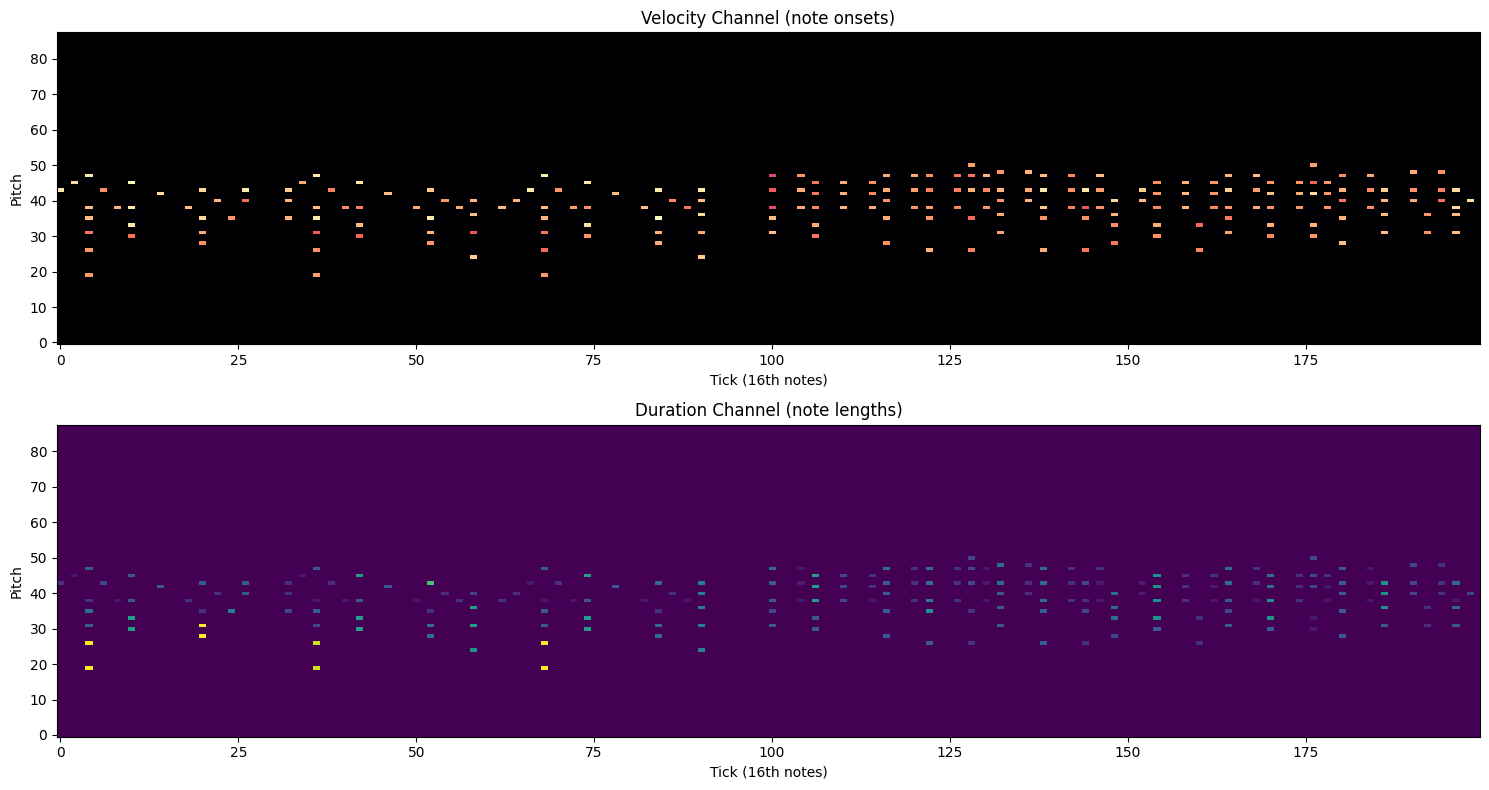

Sample sparsity: 74/200 ticks have notes (37%)


In [8]:
# Visualize sample tick sequence
if tick_sequences_by_split["train"]:
    sample = tick_sequences_by_split["train"][0][:200]  # First 200 ticks
    
    fig, axes = plt.subplots(2, 1, figsize=(15, 8))
    
    # Velocity channel
    axes[0].imshow(sample[:, :, 0].T, aspect='auto', origin='lower', cmap='magma')
    axes[0].set_xlabel('Tick (16th notes)')
    axes[0].set_ylabel('Pitch')
    axes[0].set_title('Velocity Channel (note onsets)')
    
    # Duration channel
    axes[1].imshow(sample[:, :, 1].T, aspect='auto', origin='lower', cmap='viridis')
    axes[1].set_xlabel('Tick (16th notes)')
    axes[1].set_ylabel('Pitch')
    axes[1].set_title('Duration Channel (note lengths)')
    
    plt.tight_layout()
    plt.show()
    
    # Sparsity analysis
    active_ticks = np.sum(np.any(sample[:, :, 0] > 0, axis=1))
    print(f"Sample sparsity: {active_ticks}/{len(sample)} ticks have notes ({100*active_ticks/len(sample):.0f}%)")

## 4. Create DataLoaders

In [9]:
BATCH_SIZE = 64 if DEVICE.type in ('mps', 'cuda') else 32
NUM_WORKERS = 0 if DEVICE.type == 'mps' else 4

train_dataset = TickDataset(tick_sequences_by_split["train"], SEQUENCE_LENGTH, STRIDE)
val_dataset = TickDataset(tick_sequences_by_split["validation"], SEQUENCE_LENGTH, STRIDE)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print(f"Train: {len(train_dataset):,} sequences ({len(train_loader)} batches)")
print(f"Val:   {len(val_dataset):,} sequences ({len(val_loader)} batches)")
print(f"Input shape per sequence: ({SEQUENCE_LENGTH}, {TICK_FEATURES})")

Train: 16,365 sequences (256 batches)
Val:   15,039 sequences (235 batches)
Input shape per sequence: (64, 176)


## 5. Initialize Model

In [10]:
MODEL_TYPE = "mamba"  # "mamba" or "lstm"

# Input size is now 176 (88 pitches × 2 channels: velocity + duration)
if MODEL_TYPE == "mamba":
    model = MusicMamba(
        input_size=TICK_FEATURES,  # 176 instead of 88
        d_model=256,
        d_state=16,
        n_layers=4,
        dropout=0.2
    ).to(DEVICE)
else:
    model = MusicLSTM(
        input_size=TICK_FEATURES,  # 176 instead of 88
        hidden_size=512,
        num_layers=3,
        dropout=0.3
    ).to(DEVICE)

total_params = sum(p.numel() for p in model.parameters())
print(f"Model: {MODEL_TYPE.upper()}")
print(f"Input/Output size: {TICK_FEATURES} (88 pitches × 2 channels)")
print(f"Parameters: {total_params:,}")
print(f"Device: {DEVICE}")

Model: MAMBA
Input/Output size: 176 (88 pitches × 2 channels)
Parameters: 1,849,008
Device: mps


## 6. Training

In [11]:
# Training config
NUM_EPOCHS = 50
LEARNING_RATE = 0.0005  # Slightly lower for stability
GRAD_CLIP = 1.0
EARLY_STOPPING_PATIENCE = 10

# Combined loss: BCE for velocity (first 88 dims) + MSE for duration (last 88 dims)
class TickLoss(nn.Module):
    """Combined loss for tick-based encoding: BCE for velocity + MSE for duration."""
    def __init__(self, vel_weight=1.0, dur_weight=0.5):
        super().__init__()
        self.vel_weight = vel_weight
        self.dur_weight = dur_weight
        self.bce = nn.BCEWithLogitsLoss()
        self.mse = nn.MSELoss()
    
    def forward(self, pred, target):
        # Split into velocity and duration
        pred_vel = pred[..., :NUM_PITCHES]
        pred_dur = pred[..., NUM_PITCHES:]
        target_vel = target[..., :NUM_PITCHES]
        target_dur = target[..., NUM_PITCHES:]
        
        # BCE for velocity, MSE for duration
        vel_loss = self.bce(pred_vel, target_vel)
        dur_loss = self.mse(torch.sigmoid(pred_dur), target_dur)  # Sigmoid for duration
        
        return self.vel_weight * vel_loss + self.dur_weight * dur_loss

criterion = TickLoss(vel_weight=1.0, dur_weight=0.5)

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Disable AMP for MPS+Mamba (numerical stability)
USE_AMP = DEVICE.type == 'cuda'
scaler = torch.cuda.amp.GradScaler() if USE_AMP else None

print(f"Max Epochs: {NUM_EPOCHS}")
print(f"Early Stopping: patience={EARLY_STOPPING_PATIENCE}")
print(f"Loss: BCE (velocity) + MSE (duration)")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Mixed Precision: {USE_AMP}")

Max Epochs: 50
Early Stopping: patience=10
Loss: BCE (velocity) + MSE (duration)
Learning Rate: 0.0005
Mixed Precision: False


In [12]:
def train_epoch(model, loader, criterion, optimizer, device, grad_clip, use_amp=False, scaler=None):
    model.train()
    total_loss = 0.0
    for batch_x, batch_y in loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        
        if use_amp and device.type == 'cuda':
            with torch.cuda.amp.autocast():
                output, _ = model(batch_x)
                loss = criterion(output, batch_y)
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            scaler.step(optimizer)
            scaler.update()
        else:
            output, _ = model(batch_x)
            loss = criterion(output, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()
        
        total_loss += loss.item()
    return total_loss / len(loader)


def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch_x, batch_y in loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            output, _ = model(batch_x)
            loss = criterion(output, batch_y)
            total_loss += loss.item()
    return total_loss / len(loader)

In [ ]:
# Training loop with early stopping
train_losses, val_losses = [], []
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_path = DATA_DIR / "best_model_tick.pt"
DATA_DIR.mkdir(parents=True, exist_ok=True)

print(f"Training {MODEL_TYPE.upper()} (tick-based) on {DEVICE}...")
print(f"Saving best model to: {best_model_path}\n")

total_start = time.time()

for epoch in range(NUM_EPOCHS):
    epoch_start = time.time()
    
    train_loss = train_epoch(model, train_loader, criterion, optimizer, DEVICE, GRAD_CLIP, USE_AMP, scaler)
    val_loss = validate(model, val_loader, criterion, DEVICE)
    
    scheduler.step(val_loss)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Check for improvement
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'model_type': MODEL_TYPE,
            'encoding': 'tick',
            'input_size': TICK_FEATURES,
        }, best_model_path)
        marker = " *"
    else:
        epochs_without_improvement += 1
        marker = ""
    
    # Log progress
    lr = optimizer.param_groups[0]['lr']
    elapsed = time.time() - epoch_start
    print(f"Epoch {epoch+1:3d}/{NUM_EPOCHS} | Train: {train_loss:.4f} | Val: {val_loss:.4f} | LR: {lr:.6f} | {elapsed:.1f}s{marker}")
    
    # Early stopping
    if epochs_without_improvement >= EARLY_STOPPING_PATIENCE:
        print(f"\nEarly stopping! No improvement for {EARLY_STOPPING_PATIENCE} epochs.")
        break

total_time = time.time() - total_start
print(f"\nDone! Total: {total_time/60:.1f} min, Best val loss: {best_val_loss:.4f}")

Training MAMBA (tick-based) on mps...
Saving best model to: midi_data/best_model_tick.pt



In [ ]:
# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Progress (Tick-Based Encoding)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nModel saved to: {best_model_path}")
print("Use midi_generation.ipynb to generate music!")